# Bayes analysis of SIR model with changing points


### Load libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma as sc_gamma

### Generate data


### Ground truth


In [2]:
gt_changing_points = [1, 26, 51, 76]
# gt_changing_points = [1, 51, 101, 151]
gt_total_time = 100
# gt_total_time = 200
gt_betas = [0.1, 0.4, 0.2, 0.05]
gt_gammas = [0.01, 0.08, 0.15, 0.25]
gt_total_population = 1_000_000
gt_init_infected = 50

save_npz = True

gt_changing_points_tmp = gt_changing_points.copy()
gt_changing_points_tmp.append(gt_total_time + 1)
gt_days = np.array(gt_changing_points_tmp[1:]) - np.array(gt_changing_points_tmp[:-1])
gt_beta_time = np.concatenate(
    [[beta_val] * days for beta_val, days in zip(gt_betas, gt_days)]
)
gt_gamma_time = np.concatenate(
    [[gamma_val] * days for gamma_val, days in zip(gt_gammas, gt_days)]
)

In [3]:
# gt_beta_time.shape, gt_gamma_time.shape

In [4]:
S = np.zeros(gt_total_time + 1)
I = np.zeros(gt_total_time + 1)
R = np.zeros(gt_total_time + 1)
P = np.zeros(gt_total_time + 1)
N = np.zeros(gt_total_time + 1)

N[0] = gt_total_population
S[0] = N[0] - gt_init_infected
I[0] = gt_init_infected
R[0] = 0
P[0] = I[0] / N[0]

In [5]:
for i in range(1, gt_total_time + 1):
    delta_i = np.random.binomial(
        S[i - 1], 1 - np.exp(-gt_beta_time[i - 1] * P[i - 1]))
    delta_r = np.random.binomial(I[i - 1], gt_gamma_time[i - 1])

    S[i] = S[i - 1] - delta_i
    I[i] = I[i - 1] + delta_i - delta_r
    R[i] = R[i - 1] + delta_r
    N[i] = S[i] + I[i] + R[i]
    P[i] = I[i] / N[i]

if save_npz:
    np.savez(
        "gt_data.npz",
        S=S,
        I=I,
        R=R,
        # beta_time=gt_beta_time,
        # gamma_time=gt_gamma_time,
    )

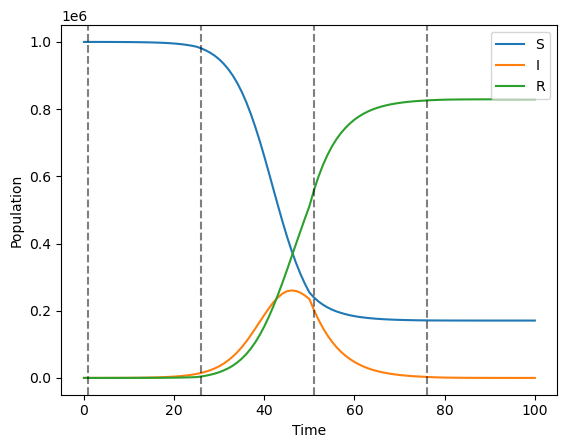

In [6]:
def plot_population_data(S, R, I, gt_changing_points):
    """
    Plots the population data for susceptible (S), recovered (R), and infected (I) individuals over time.

    Parameters:
    S (array-like): Array of susceptible population counts over time.
    R (array-like): Array of recovered population counts over time.
    I (array-like): Array of infected population counts over time.

    Returns:
    None
    """
    plt.plot(S, label="S")
    plt.plot(I, label="I")
    plt.plot(R, label="R")
    for c_point in gt_changing_points:
        plt.axvline(x=c_point, color="black", linestyle="--", alpha=0.5)
    plt.xlabel("Time")
    plt.ylabel("Population")
    plt.legend()
    plt.show()


plot_population_data(S, R, I, gt_changing_points)

## Loading the data from the file


In [7]:
if save_npz:
    data = np.load("gt_data.npz")
    S = data["S"]
    I = data["I"]
    R = data["R"]

In [8]:
S_0 = S[0]
I_0 = I[0]
R_0 = R[0]
N_0 = S_0 + I_0 + R_0
P_0 = I_0 / N_0

S = S[1:]
I = I[1:]
R = R[1:]
P = I / N_0

T = len(S)

Delta_I = np.concatenate([[I_0], S[:-1] - S[1:]])
Delta_R = np.concatenate([[R_0], R[1:] - R[:-1]])

In [9]:
# MCMC parameters

p = 0.01
n_samplings = 25_000

In [10]:
# define the prior distributions
def prior_delta(T, p):
    """
    Generate a prior distribution for the delta parameter in the Bayesian SIR model.

    Parameters:
    - T (int): The length of the time series.
    - p (float): The probability of success for the binomial distribution.

    Returns:
    - numpy.ndarray: An array representing the prior distribution for the delta parameter.
    """
    # the first element has to be 1
    return np.concatenate([[1], np.random.binomial(1, p, size=T - 1)])


def prior_r(K: int):
    """
    Generate prior values for the parameter r.

    Parameters:
    K (int): The number of prior values to generate.

    Returns:
    numpy.ndarray: An array of size K containing the prior values for r.
    """
    return np.random.gamma(shape=0.1, scale=0.1, size=K)


def prior_b(K):
    """
    Generate prior samples for parameter b in the Bayesian SIR model.

    Parameters:
    K (int): Number of samples to generate.

    Returns:
    numpy.ndarray: Array of shape (K,) containing the prior samples for parameter b.
    """
    return np.random.gamma(shape=0.1, scale=0.1, size=K)


def prior_gamma(delta, r):
    """
    Generate a prior gamma value based on the given delta and r parameters.

    Parameters:
    delta (array-like): An array-like object containing delta values.
    r (array-like): An array-like object containing r values.

    Returns:
    float: The generated gamma value.

    """
    eta = np.cumsum(delta)
    gamma = np.random.beta(a=r[eta - 1], b=1)
    return gamma


def prior_beta(delta, b):
    """
    Generate a prior sample of beta based on the given delta and b values.

    Parameters:
    delta (array-like): An array-like object containing delta values.
    b (array-like): An array-like object containing b values.

    Returns:
    float: A random sample of beta.

    """
    eta = np.cumsum(delta)
    beta = np.random.exponential(scale=1 / b[eta - 1])
    return beta

In [11]:
# define the sampling parameters

delta = np.zeros((n_samplings, T), dtype=int)
r = np.zeros((n_samplings, T))
b = np.zeros((n_samplings, T))
beta = np.zeros((n_samplings, T))
gamma = np.zeros((n_samplings, T))
K = np.zeros(n_samplings, dtype=int)
eta = np.zeros((n_samplings, T), dtype=int)

In [12]:
def init_mcmc(T, p):
    """
    Initialize the Markov Chain Monte Carlo (MCMC) parameters for the Bayesian SIR model.

    Parameters:
    - T (int): The number of time steps.
    - p (float): The probability of infection.

    Returns:
    None
    """

    delta_tmp = prior_delta(T, p)
    K_0 = np.sum(delta_tmp)
    r_temp = prior_r(K_0)
    b_temp = prior_b(K_0)

    delta[0, :] = delta_tmp
    r[0, 0:K_0] = r_temp
    b[0, 0:K_0] = b_temp
    gamma[0, :] = prior_gamma(delta_tmp, r_temp)
    beta[0, :] = prior_beta(delta_tmp, b_temp)
    eta[0, :] = np.cumsum(delta_tmp)
    K[0] = K_0

In [13]:
def safe_log(x):
    """
    Compute the logarithm of the input array, handling values close to zero.

    Parameters:
    x (array-like): Input array.

    Returns:
    array-like: The logarithm of the input array. Values close to zero are replaced with -744.

    """
    try:
        x = np.array(x)
        mask = x > 1e-323
        output = np.zeros(len(x))
        output[mask] = np.log(x[mask])
        output[~mask] = -744
        return output
    except:
        return np.log(x) if x > 0 else -744

In [14]:
# init the matrixes
init_mcmc(T, p)

In [15]:
def add(delta_):
    """
    Adds a value of 1 to the first occurrence of 0 in the input array.

    Parameters:
    delta_ (numpy.ndarray): The input array.

    Returns:
    numpy.ndarray: The modified array with the first occurrence of 0 replaced by 1.
    """
    index_tmp = np.where(delta_ == 0)[0]
    np.random.shuffle(index_tmp)
    zero_index = index_tmp[0]
    delta_[zero_index] = 1
    return delta_


def delete(delta_):
    """
    Deletes a randomly selected element with value 1 from the input array.

    Parameters:
    delta_ (numpy.ndarray): The input array.

    Returns:
    numpy.ndarray: The modified array with a randomly selected element set to 0.
    """
    index_tmp = np.where(delta_ == 1)[0]
    np.random.shuffle(index_tmp)
    zero_index = index_tmp[0]
    if zero_index == 0:
        # raise IndexError("Cannot delete the first element.")
        pass
    else:
        delta_[zero_index] = 0
    return delta_


def swap(delta_):
    """
    Swaps the elements of the input array `delta_` in a random manner provieded
    that one of them is equal to 1 and the other is equal to 0.

    Parameters:
    delta_ (array-like): The input array to be shuffled.

    Returns:
    array-like: The shuffled array.

    """
    delta_ = delta_[1:]
    tmp = delta_[1:] + delta_[:-1]

    index_tmp = np.where(tmp == 1)[0] + 1
    np.random.shuffle(index_tmp)
    shuffling_index = index_tmp[0]

    tmp_value = delta_[shuffling_index - 1]
    delta_[shuffling_index - 1] = delta_[shuffling_index]
    delta_[shuffling_index] = tmp_value

    return np.concatenate([[1], delta_])

In [16]:
def log_likelihood(beta, gamma, delta, K):
    """
    Calculate the log-likelihood of the Bayesian SIR model.

    Parameters:
    - beta (numpy.ndarray): Array of infection rates.
    - gamma (numpy.ndarray): Array of recovery rates.
    - delta (numpy.ndarray): Array of time steps between consecutive infections.
    - K (int): Maximum number of regimes.

    Returns:
    - float: The log-likelihood value.

    """
    eta = np.cumsum(delta)
    sum_ = 0
    for k in range(1, K + 1):
        mask_ = eta == k
        n = np.sum(mask_)

        sum_beta = np.sum(beta[mask_])
        sum_gamma = np.sum(safe_log(gamma[mask_]))

        sum_ += 0.2 * safe_log(0.1) - 2 * safe_log(sc_gamma(0.1))
        sum_ += 2 * safe_log(sc_gamma(0.1 + n))
        sum_ -= (0.1 + n) * safe_log((0.1 + sum_beta) * (0.1 - sum_gamma))
    return sum_

In [17]:
def log_J_ratio(K_g, K_, T):
    k_k = (K_, K_g)
    if K_ == K_g:
        return 0  # np.log(1)
    elif k_k == (1, 2) or k_k == (T, T - 1):
        return np.log(3 / (T - 1))
    elif k_k == (2, 1) or k_k == (T - 1, T):
        return np.log((T - 1) / 3)
    elif K_g == K_ + 1:
        return np.log((K_g - 1) / (T - K_))
    elif K_g == K_ - 1:
        return np.log((T - K_) / (K_g - 1))
    else:
        raise Exception("J_ratio is wrong")

In [18]:
# MCMC procedure
for n in range(1, n_samplings):
    # load for convenience
    beta_g = beta[n - 1, :]
    gamma_g = gamma[n - 1, :]
    delta_g = delta[n - 1, :]
    K_g = K[n - 1]

    # Update delta
    # propose the move for delta
    delta_ = delta_g[:]
    if K_g == 1:  # add
        delta_ = add(delta_)
    elif K_g == T:  # delete
        delta_ = delete(delta_)
    else:  # random
        case = np.random.random()
        if case < 1 / 3:
            delta_ = add(delta_)
        elif case < 2 / 3:
            delta_ = delete(delta_)
        else:
            delta_ = swap(delta_)
    K_ = np.sum(delta_)

    # metropolis hastings for delta
    mh = (
        (K_ - K_g) * np.log(p / (1 - p))
        + log_likelihood(beta_g, gamma_g, delta_, K_)
        - log_likelihood(beta_g, gamma_g, delta_, K_g)
        + log_J_ratio(K_g, K_, T)
    )

    temp_ = np.log(np.random.random())
    if mh > temp_:
        delta[n, :] = delta_
        # delta_g = delta_
    else:
        delta[n, :] = delta_g

    # updated K and eta
    K[n] = int(np.sum(delta[n, :]))
    eta[n, :] = np.cumsum(delta[n, :], dtype=int)

    # update b and r
    for k in range(K[n]):
        shape_b = 0.1 + np.sum(eta[n, :] == k)
        scale_b = 0.1 + np.sum(beta_g[eta[n, :] == k])

        shape_r = shape_b
        scale_r = 0.1 + np.sum(-safe_log(gamma_g[eta[n, :] == k]))

        b[n, k] = np.random.gamma(shape=shape_b, scale=scale_b, size=1)
        r[n, k] = np.random.gamma(shape=shape_r, scale=scale_r, size=1)

    # update beta and gamma
    for t in range(T):
        if t == 0:
            y = np.random.beta(
                a=(S_0 - Delta_I[t]) + b[n, eta[n, t] - 1] + 1,
                b=Delta_I[t] + 1,
            )
            beta[n, t] = -safe_log(y) / P_0
            gamma[n, t] = np.random.beta(
                a=Delta_R[t] + r[n, eta[n, t] - 1],
                b=1 + I_0 - Delta_R[t],
            )
        else:
            y = np.random.beta(
                a=(S[t - 1] - Delta_I[t]) + b[n, eta[n, t] - 1] + 1,
                b=Delta_I[t] + 1,
            )
            beta[n, t] = -safe_log(y) / P[t - 1]
            gamma[n, t] = np.random.beta(
                a=Delta_R[t] + r[n, eta[n, t] - 1],
                b=1 + I[t - 1] - Delta_R[t],
            )

In [26]:
q = np.zeros((T, T))
for t_prime in range(0, T):
    for t in range(0, t_prime):
        q[t, t_prime] = np.mean(eta[:, t] == eta[:, t_prime])